## 1. Import Dependancies

In [352]:
import pandas as pd # pandas==1.4.1
import numpy as np # numpy==1.21.5
from matplotlib import pyplot as plt # matplotlib==3.5.1
import seaborn as sns # seaborn==0.11.2
from sklearn.compose import ColumnTransformer # scikit-learn==1.0.2
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.exceptions import NotFittedError

## 2. Import Data

In [330]:
# Import data and assign column names
data_fpath = '../data/GSOC_Data_DataCube.txt'
colnames_observable = ['od','od_uncertainty','max_ev','max_ev_uncertainty','flux300']
colnames_physical = ['mass_total','mass_Ni','energy','mass_distribution','radial_distribution']
df = pd.read_csv(data_fpath, sep=' ', names=colnames_observable+colnames_physical)
df.head()

,od,od_uncertainty,max_ev,max_ev_uncertainty,flux300,mass_total,mass_Ni,energy,mass_distribution,radial_distribution
0,1.940628,0.179354,0.013531,0.000670,0.000003,0.75,0.15,0.75,hed8,hed8
1,2.071999,0.210287,0.012423,0.000615,0.000003,0.75,0.15,0.75,hed8,mwd
2,2.007982,0.198804,0.012744,0.000685,0.000003,0.75,0.15,0.75,hed8,N100
3,1.661535,0.189436,0.009935,0.000349,0.000003,0.75,0.15,0.75,hed8,w7dt
4,1.907672,0.178607,0.013343,0.000745,0.000003,0.75,0.15,2.00,hed8,hed8


In [68]:
# Creating a mapped dictionary of units
units = dict(zip(colnames_observable,['','','s⁻¹','s⁻¹','cm⁻²s⁻¹']))
units.update(dict(zip(colnames_physical,['M☉','M☉','10⁵¹ ergs','',''])))
units

{'od': '',
 'od_uncertainty': '',
 'max_ev': 's⁻¹',
 'max_ev_uncertainty': 's⁻¹',
 'flux300': 'cm⁻²s⁻¹',
 'mass_total': 'M☉',
 'mass_Ni': 'M☉',
 'energy': '10⁵¹ ergs',
 'mass_distribution': '',
 'radial_distribution': ''}

In [85]:
# Check columns for missing values and data-type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   od                   512 non-null    float64
 1   od_uncertainty       512 non-null    float64
 2   max_ev               512 non-null    float64
 3   max_ev_uncertainty   512 non-null    float64
 4   flux300              512 non-null    float64
 5   mass_total           512 non-null    float64
 6   mass_Ni              512 non-null    float64
 7   energy               512 non-null    float64
 8   mass_distribution    512 non-null    object 
 9   radial_distribution  512 non-null    object 
dtypes: float64(8), object(2)
memory usage: 40.1+ KB


- No missing data present.
- Columns 1 through 8 are numerical; 9 and 10 are strings.
- 512 data points is limited, we might need to find a way to upsample the dataset.

## 3. Exploratory Data Analysis

### 3.1. Step 1 - Observable Parameters (Input Features)

In [87]:
# Show column statistics since all observable parameters are numerical data
df_obs = df.loc[:,colnames_observable]
df_obs.describe().iloc[1:]

,od,od_uncertainty,max_ev,max_ev_uncertainty,flux300
mean,2.576275,0.198927,0.012814,0.000512,0.000007
std,0.391005,0.021055,0.000849,0.000074,0.000004
min,1.661535,0.133992,0.009842,0.000313,0.000003
25%,2.321794,0.183659,0.012372,0.000458,0.000003
50%,2.559251,0.198672,0.012891,0.000501,0.000006
75%,2.812090,0.215768,0.013388,0.000556,0.000011
max,3.621963,0.239162,0.014723,0.000817,0.000015


In [134]:
# Obtain the relative uncertainties of optical depth
od_uncertainty_pct = df_obs.od_uncertainty / df_obs.od
od_uncertainty_pct.describe().iloc[1:]

mean    0.078545
std     0.011796
min     0.047808
25%     0.069775
50%     0.078088
75%     0.086126
max     0.114326
dtype: float64

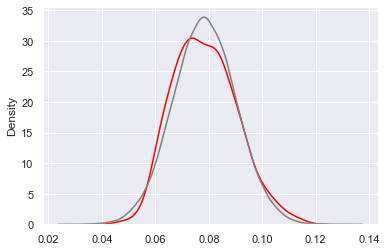

In [417]:
# Distribution of relative uncertainties of optical depth compared to a normal distribution
fig, ax = plt.subplots()
sns.kdeplot(od_uncertainty_pct,ax=ax,color='red')
normal = np.random.normal(loc=od_uncertainty_pct.mean(),\
    scale=od_uncertainty_pct.std(),size=10**5)
sns.kdeplot(normal,ax=ax,color='grey')
plt.show()

In [135]:
# Obtain the relative uncertainties of maximum expansion velocity compared to a normal distribution
max_ev_uncertainty_pct = df_obs.max_ev_uncertainty / df_obs.max_ev
max_ev_uncertainty_pct.describe().iloc[1:]

mean    0.039927
std     0.005138
min     0.026519
25%     0.036309
50%     0.039165
75%     0.042926
max     0.063529
dtype: float64

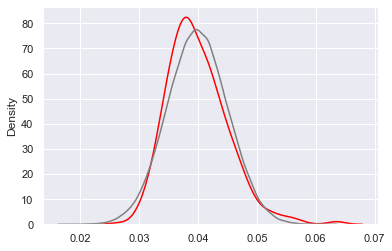

In [419]:
# Distribution of relative uncertainties of maximum expansion velocity
fig, ax = plt.subplots()
sns.kdeplot(max_ev_uncertainty_pct,ax=ax,color='red')
normal = np.random.normal(loc=max_ev_uncertainty_pct.mean(),\
    scale=max_ev_uncertainty_pct.std(),size=10**5)
sns.kdeplot(normal,ax=ax,color='grey')
plt.show()

- The maximum uncertainty for optical depth is 11.4% and is normally distributed.
    - mean=0.078545, std=0.011796
- The maximum uncertainty for the maximum expansion velocity is 6.4% and is normally distributed.
    - mean=0.039927, std=0.005138
- We can use the mean and standard deviation percentages to bootstrap the existing dataset to create new features for training to obtain a more robust classification model.

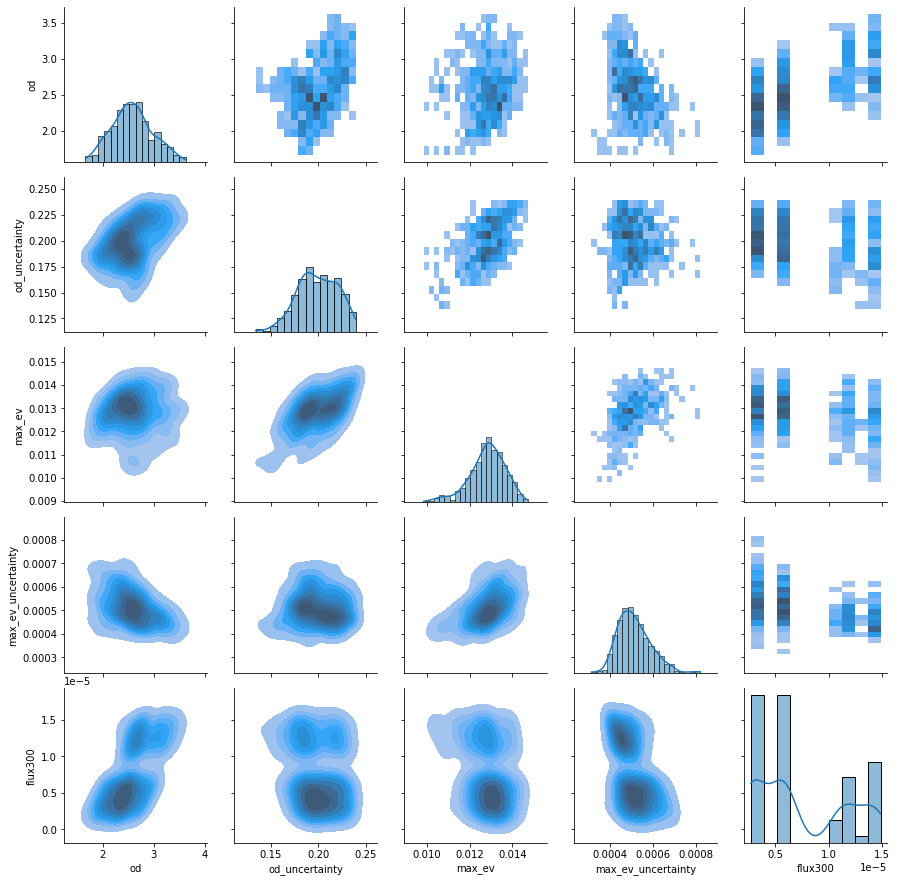

In [121]:
# Pairplot
g = sns.PairGrid(df_obs)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

- Data for optical depth and maximum expansion velocity seems to be normally distributed. 
- The histogram for emergent flux seems to be missing alot of bins. 
- Uncertainties of optical depth and maximum expansion velocity seems to be positively correlated. Which suggests that a percent-wise bootstrapping is feasible.
- Optical depth and flux seems to be positively correlated.
- Maximum expansion velocity and flux seems to have little relation. 
- Maximum expansion velocity and optical depth seems to have little relation. 

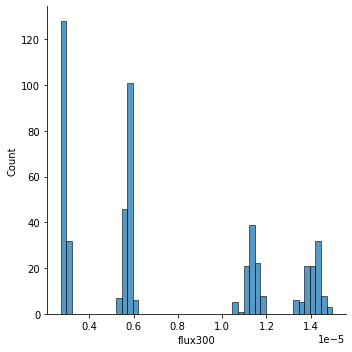

In [155]:
# Examine flux data
sns.displot(df_obs.flux300, binwidth=2.5e-7)
plt.show()

- Flux values seem to have 4 distinct bins:
    - 0.1e-5 to 0.3e-5
    - 0.5e-5 to 0.65e-5
    - 1.0e-5 to 1.2e-5
    - 1.3e-5 to 1.6e-5
- We can consider splitting these into 4 categories between the following values: [0, 0.4e-5, 0.85e-5, 1.25e-5, 1.6e-5]

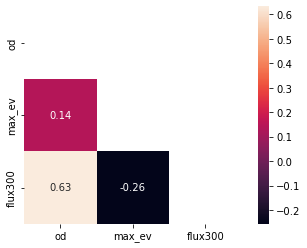

In [168]:
# Pearsons correlation heatmap of features
corr = df_obs.iloc[:,[0,2,4]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, square=True, annot=True)
plt.show()

- Since flux is highly positively correlated to optical depth, and moderately negatively correlated to maximum expansion velocity, converting flux to a categorical feature might aid in preventing multicollinearity of our features.

### 3.2. Step 2 - Physical Parameters (Target Features)

In [331]:
# Show column statistics since all physical parameters that are numerical
df_phy = df.loc[:,colnames_physical]
df_phy.describe().iloc[1:]

,mass_total,mass_Ni,energy
mean,1.518750,0.393750,1.375000
std,0.434834,0.230629,0.625611
min,0.750000,0.150000,0.750000
25%,1.300000,0.150000,0.750000
50%,1.600000,0.300000,1.375000
75%,1.850000,0.600000,2.000000
max,2.000000,0.750000,2.000000


In [332]:
# Counts of mass distributions
df_phy.mass_distribution.value_counts()

hed8    128
mwd     128
N100    128
w7dt    128
Name: mass_distribution, dtype: int64

In [172]:
# Counts of radial distributions
df_phy.radial_distribution.value_counts()

hed8    128
mwd     128
N100    128
w7dt    128
Name: radial_distribution, dtype: int64

In [213]:
# Counts of mass and radial distribution permutations
distribution_flags = df_phy.mass_distribution+'-'+df_phy.radial_distribution
distribution_flags.value_counts()

hed8-hed8    32
hed8-mwd     32
hed8-N100    32
hed8-w7dt    32
mwd-hed8     32
mwd-mwd      32
mwd-N100     32
mwd-w7dt     32
N100-hed8    32
N100-mwd     32
N100-N100    32
N100-w7dt    32
w7dt-hed8    32
w7dt-mwd     32
w7dt-N100    32
w7dt-w7dt    32
dtype: int64

- It seems that there are 32 points of data for each possible permutation of distribution.
- Therefore, we shall next find out how the mass and radial distributions correlate to our numerical data distributions.

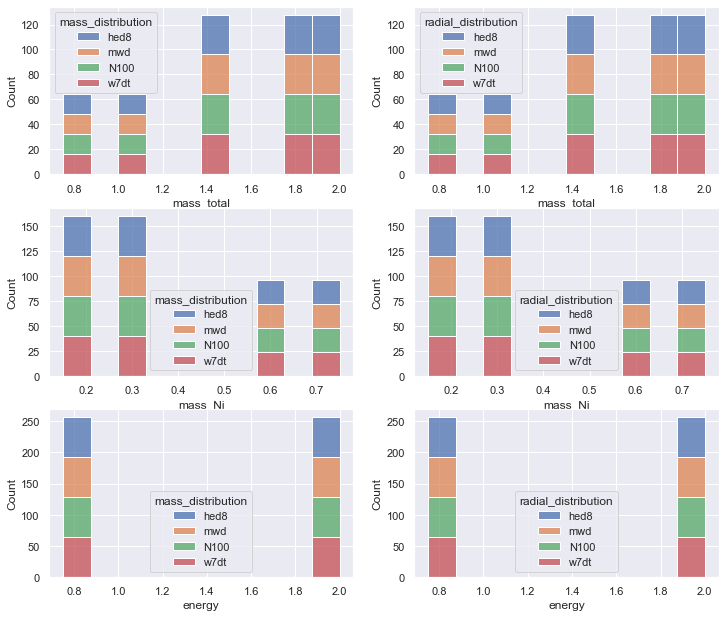

In [208]:
fig, axs = plt.subplots(3,2)
fig.set_size_inches(12, 10.5)
for i, num_col in enumerate(df_phy.columns[:3]):
    for j, cat_col in enumerate(df_phy.columns[3:]):
        sns.histplot(data=df_phy,x=num_col,hue=cat_col,multiple="stack",ax=axs[i,j])
plt.show()

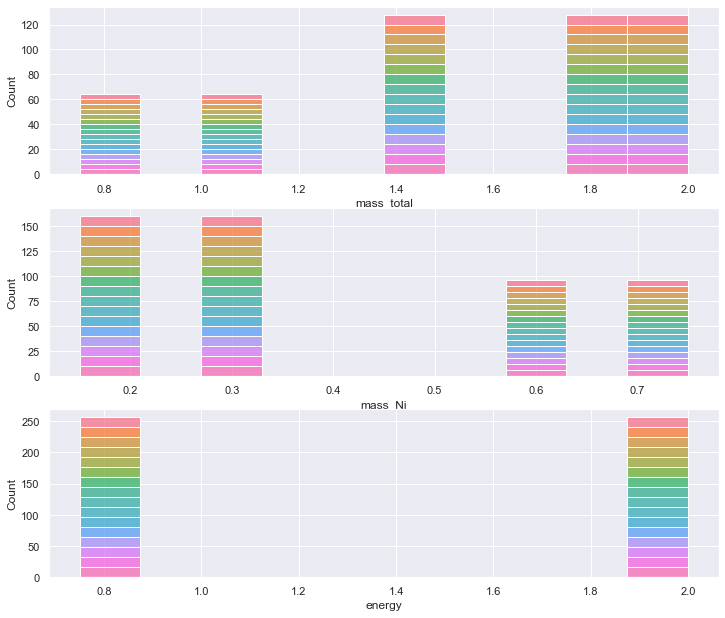

In [215]:
fig, axs = plt.subplots(3,1)
fig.set_size_inches(12, 10.5)
for i, num_col in enumerate(df_phy.columns[:3]):
    sns.histplot(data=df_phy,x=num_col,hue=distribution_flags,multiple="stack",ax=axs[i],legend=False)
plt.show()

- It seems like the mass and radial distributions are evenly split into our numerical target data.
- I suspect that our numerical data is categorical, lets check.

In [227]:
for col in df_phy.columns[:3]:
    print(f'{col}:','value\tcount',df_phy[col].value_counts(),sep='\n',end="\n\n")

mass_total:
value	count
1.40    128
1.80    128
2.00    128
0.75     64
1.00     64
Name: mass_total, dtype: int64

mass_Ni:
value	count
0.15    160
0.30    160
0.60     96
0.75     96
Name: mass_Ni, dtype: int64

energy:
value	count
0.75    256
2.00    256
Name: energy, dtype: int64



- The numerical columns in our physical data is indeed categorical, these can be transformed into ordinal data for further analysis.
    - There are 5 distinct values for total mass.
    - There are 4 distinct values for nickel mass.
    - There are 2 distinct values for energy.
- For the categorical columns:
    - There are 2 distinct categories for the mass distribution flag.
    - There are 2 distinct categories for the radial distribution flag.

Next, we will check the distinct combinations in our dataset versus the possible combinations with these categories.

In [240]:
# Get the number of distinct permutions in the target dataset
distinct = len(df_phy.value_counts())
possible = np.prod([len(df_phy[x].unique()) for x in df_phy.columns])
print(f'The number of distinct permutions is {distinct}.')
print(f'The number of possible permutions is {possible}.')

The number of distinct permutions is 512.
The number of possible permutions is 640.


- This means that there are some combinations of our target features which are either:
    1. Not available for in our target dataset.
    2. Not possible or cannot exist.
- Either way, we will have to train and predict for individual physical targets in order to get a possible prediction on a non-existent target permutation.

### 3.3. Step 2 - Connection Between Observable and Physical Parameters 

- Lets have a quick look at the relationship between all parameters
- A quick way is to generate a pair plot and a correlation matrix.

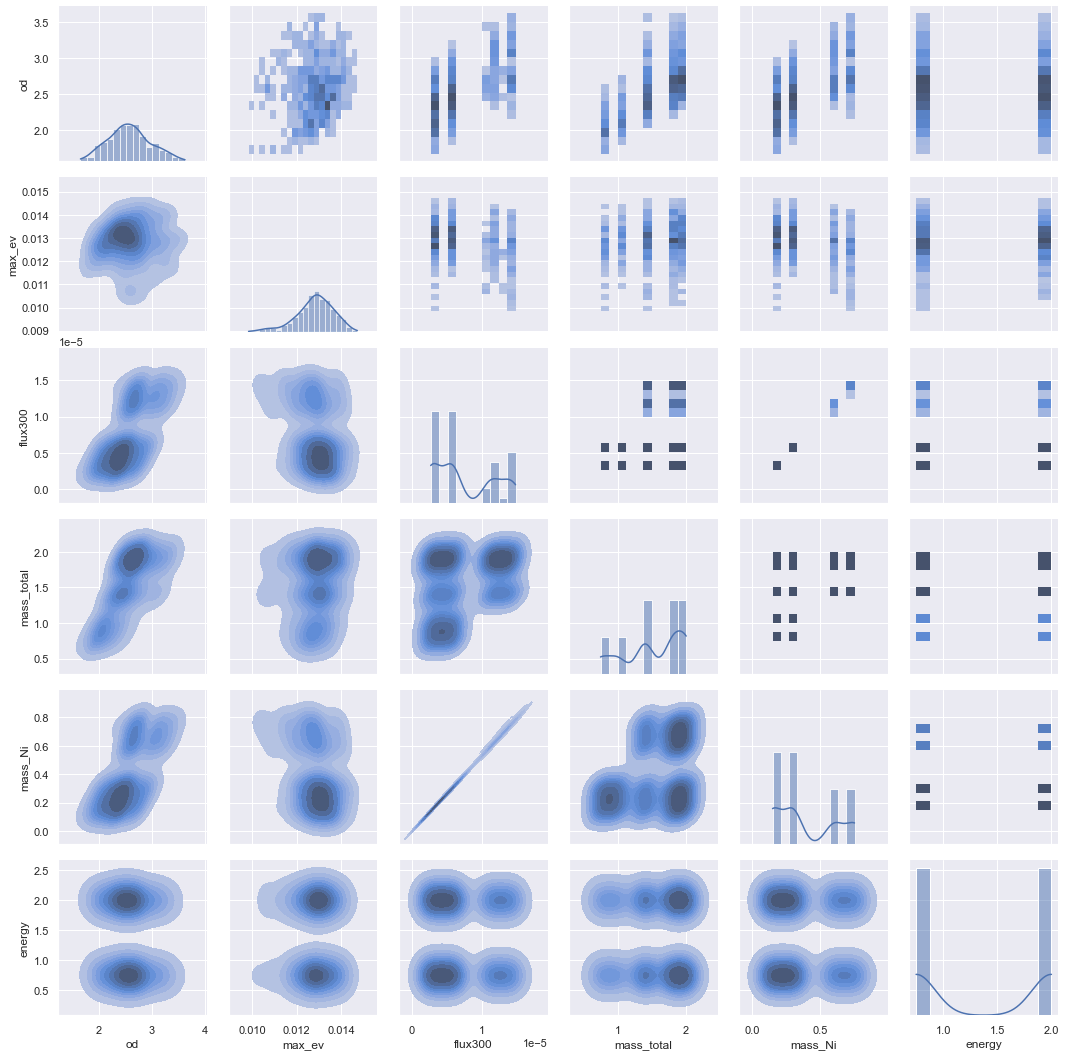

In [379]:
# Pair plot
g = sns.PairGrid(df.iloc[:,[0,2,4,5,6,7]])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)
plt.show()

- From the pair plot, the most noticable relationships for each physical parameters are:
    - Flux and nickel mass, it is highly positively and linearly correlated. 
    - OD and total mass, seems to be moderately correlated.
    - Energy does not seem correlated to any observable feature. However, it is hard to visualize as there are only 2 values for energy.
- Lets look at the correlation matrix.

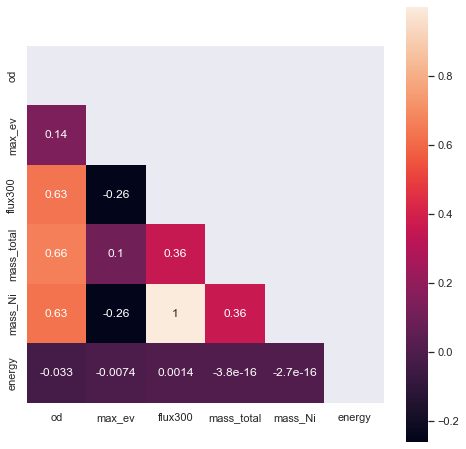

In [432]:
# Pearsons correlation matrix of all features
corr = df.iloc[:,[0,2,4,5,6,7]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=mask, square=True, annot=True)
plt.show()

- As expected, energy may be the most difficult target feature to predict as it shows little linear correlation to any input/observable features.
- It is possible that the variation in the 4 bins of flux could be useful in determining the energy.
- Lets test 1 bin (lowest bin) to verify.

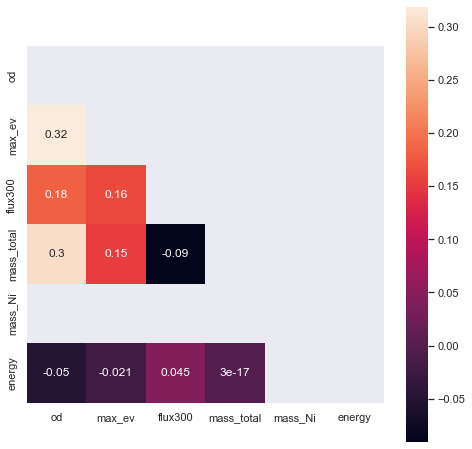

In [437]:
# Test correlation for flux>=<0.4e-5
df[df.flux300<0.4e-5]
corr = df[df.flux300>=1.25e-5].iloc[:,[0,2,4,5,6,7]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=mask, square=True, annot=True)
plt.show()

- The pearson correlation between flux and energy has increased by 3 fold. 
- With this in mind, we shall maintain the flux column, and add a column in our input dataset which classifies. 

## 4. Step 3 - Classification
### 4.1. Feature Engineer / Pre-process Input Features

### 4.2. Feature Engineer / Pre-process Target Features

In [424]:
class target_preprocessor:
    """Class object to pre-process the target dataset.
    Performs an ordinal (ordered) encoding for the total mass, nickel mass, energy.
    Performs a nominal (one-hot) encoding for the mass and radial distribution flags.
    """
    def __init__(self):
        self.fitted = False
        pass

    def fit(self,y):
        """Method to fit the dataset classes.
        """
        self._mass_total_map = dict(zip(y.mass_total.unique(),range(len(y.mass_total))))
        self._mass_Ni_map = dict(zip(y.mass_Ni.unique(),range(len(y.mass_Ni))))
        self._energy_map = dict(zip(y.energy.unique(),range(len(y.energy))))
        self._mass_distribution_list = y.mass_distribution.unique()[1:]        # Drop first is True
        self._radial_distribution_list = y.radial_distribution.unique()[1:]    # Drop first is True
        self._enc = OneHotEncoder(categories=[self._mass_distribution_list,self._radial_distribution_list], \
            handle_unknown='ignore')
        self._in_columns = list(y.columns)
        self._out_columns = list(y.columns[:3]) + \
            ['mass_is_'+x for x in self._mass_distribution_list] + \
            ['rad_is_'+x for x in self._radial_distribution_list]
        self.fitted = True
        
    def transform(self,y):
        """Method to transform/encode the dataset.
        """
        if self.fitted:
            y = y.copy()
            y.mass_total = y.mass_total.apply(lambda x: float(self._mass_total_map[x]))
            y.mass_Ni = y.mass_Ni.apply(lambda x: float(self._mass_Ni_map[x]))
            y.energy = y.energy.apply(lambda x: float(self._energy_map[x]))
            dist_df = pd.DataFrame(self._enc.fit_transform(y[['mass_distribution','radial_distribution']]).toarray(), \
                columns=self._out_columns[3:])
            y.drop(['mass_distribution','radial_distribution'],axis=1,inplace=True)
            transformed = pd.concat([y,dist_df],axis=1)
            return transformed
        else:
            raise NotFittedError(
                'This preprocessor has yet to be fitted.'
            )
    
    def fit_transform(self,y):
        """Method to fit and then transform the dataset.
        """
        self.fit(y)
        self.fitted = True
        return self.transform(y)
    
    def inverse_transform(self,y):
        """Method to inversely transform the dataset.
        """
        inv_transform = pd.DataFrame()
        dist_df = self._enc.inverse_transform(y.iloc[:,3:])
        inv_mass_total_map = {v: k for k, v in self._mass_total_map.items()}
        inv_mass_Ni_map = {v: k for k, v in self._mass_Ni_map.items()}
        inv_energy_map = {v: k for k, v in self._energy_map.items()}
        inv_transform['mass_total'] = y.mass_total.map(inv_mass_total_map)
        inv_transform['mass_Ni'] = y.mass_Ni.map(inv_mass_Ni_map)
        inv_transform['energy'] = y.energy.map(inv_energy_map)
        inv_transform['mass_distribution'] = dist_df[:,0]
        inv_transform['radial_distribution'] = dist_df[:,1]
        inv_transform.fillna('hed8', inplace=True)
        return inv_transform
        
TP = target_preprocessor()

In [431]:
df_phy.head()

,mass_total,mass_Ni,energy,mass_distribution,radial_distribution
0,0.75,0.15,0.75,hed8,hed8
1,0.75,0.15,0.75,hed8,mwd
2,0.75,0.15,0.75,hed8,N100
3,0.75,0.15,0.75,hed8,w7dt
4,0.75,0.15,2.00,hed8,hed8


In [428]:
targets = TP.fit_transform(df_phy).head()
targets

,mass_total,mass_Ni,energy,mass_is_mwd,mass_is_N100,mass_is_w7dt,rad_is_mwd,rad_is_N100,rad_is_w7dt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [429]:
TP.inverse_transform(targets).head()

,mass_total,mass_Ni,energy,mass_distribution,radial_distribution
0,0.75,0.15,0.75,hed8,hed8
1,0.75,0.15,0.75,hed8,mwd
2,0.75,0.15,0.75,hed8,N100
3,0.75,0.15,0.75,hed8,w7dt
4,0.75,0.15,2.00,hed8,hed8
